In [1]:
import tsdb
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from data_processor import DataProcessor

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

data = tsdb.load('physionet_2012')


2024-12-05 14:24:55 [INFO]: You're using dataset physionet_2012, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/physionet_2012
2024-12-05 14:24:55 [INFO]: Dataset physionet_2012 has already been downloaded. Processing directly...
2024-12-05 14:24:55 [INFO]: Dataset physionet_2012 has already been cached. Loading from cache directly...
2024-12-05 14:24:55 [INFO]: Loaded successfully!


## Data voorbereiden

In [2]:
print(data.keys())
df_a  = pd.DataFrame(data['set-a'])
df_outcomes_a  = pd.DataFrame(data['outcomes-a']).reset_index()
df_static_features  = pd.DataFrame(data['static_features'])

id = "RecordID"
time = "Time"
global_features = list(df_static_features.iloc[:,0])

print(df_a.shape, len(df_a[id].unique()))
df_a.head(3)
# df_outcomes_a.head(50)

dict_keys(['set-a', 'set-b', 'set-c', 'outcomes-a', 'outcomes-b', 'outcomes-c', 'static_features'])
(180552, 43) 3997


Parameter,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Gender,Glucose,HCO3,HCT,HR,Height,ICUType,K,Lactate,MAP,MechVent,Mg,NIDiasABP,NIMAP,NISysABP,Na,PaCO2,PaO2,Platelets,RecordID,RespRate,SaO2,SysABP,Temp,Time,TroponinI,TroponinT,Urine,WBC,Weight,pH
0,NaN,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,NaN,NaN,NaN,75.0,-1.0,4.0,NaN,NaN,NaN,NaN,NaN,61.5,91.665,152.0,NaN,NaN,NaN,NaN,132539,19.0,NaN,NaN,35.35,0,NaN,NaN,480.0,NaN,-1.0,NaN
1,NaN,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,62.0,87.000,137.0,NaN,NaN,NaN,NaN,132539,18.0,NaN,NaN,NaN,1,NaN,NaN,30.0,NaN,NaN,NaN
2,NaN,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,52.0,75.670,123.0,NaN,NaN,NaN,NaN,132539,19.0,NaN,NaN,NaN,2,NaN,NaN,170.0,NaN,NaN,NaN


In [3]:
processor = DataProcessor(
    df=df_a, 
    id_col=id, 
    time_col=time,
    global_features=global_features,
    max_wanted_len=5000
)

# Apply processing steps
processor.replace_global_features_with_nan()
processor.zscore_transformation(cols_exclude=[id, time])
processor.melt_dataframe()
processor.merge_label(df_label=df_outcomes_a, target="In-hospital_death")
processor.tokenizer()
processor.df_to_3dtensor()


melted_df = processor.return_()
melted_3dtensor = processor.return_("3dtensor")
label_tensor = processor.return_("label_tensor")

# Display the first 50 rows of the processed melted DataFrame
print(melted_3dtensor.shape)
print(label_tensor.shape)
print(melted_df.head())

max_wanted_len is larger than the number of timestamps in the data: 5000. Data has a max of: 631
torch.Size([3997, 631, 3])
torch.Size([3997])
   RecordID  Time  event     value  In-hospital_death
0    132539     0      0 -0.584118                  0
1    132539     0      1  0.905648                  0
2    132539     0      2 -1.126121                  0
3    132539     0      3 -0.664478                  0
4    132539     0      4 -1.039968                  0


In [4]:
index = 3147
print(melted_3dtensor[index][0][0].item())
print(df_outcomes_a.iloc[index].values)
print(label_tensor[index].item())
melted_df.query("RecordID==132539")

0.0
[140501      0]
0.0


,RecordID,Time,event,value,In-hospital_death
0,132539,0,0,-0.584118,0
1,132539,0,1,0.905648,0
2,132539,0,2,-1.126121,0
3,132539,0,3,-0.664478,0
4,132539,0,4,-1.039968,0
...,...,...,...,...,...
259,132539,47,7,0.149379,0
260,132539,47,8,0.403089,0
261,132539,47,9,0.615305,0
262,132539,47,10,0.510532,0


## Algoritme
We hebben nu melted_3dtensor en label_tensor als input en labels

In [14]:
melted_3dtensor = melted_3dtensor.float()
label_tensor = label_tensor.long()
print(melted_3dtensor.size(), label_tensor.size())

torch.Size([3997, 631, 3]) torch.Size([3997])


In [15]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    melted_3dtensor, label_tensor, test_size=0.2, random_state=42
)

# Split the train_data further into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)

# Verify the split
print(f"Training set size: {train_data.shape[0]}")
print(f"Validation set size: {val_data.shape[0]}")
print(f"Test set size: {test_data.shape[0]}")

Training set size: 2557
Validation set size: 640
Test set size: 800


In [26]:
import torch
import torch.nn as nn

class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionModel, self).__init__()
        # Linear layer to process the input sequence into hidden features
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()

        # Attention scoring mechanism
        self.attention_score = nn.Linear(hidden_dim, 1)

        # Output layer to map attention-weighted input to output classes
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_length, input_dim)
        """
        # Step 1: Transform input using the first layer
        x = self.fc(x)  # (batch_size, seq_length, hidden_dim)
        x = self.relu(x)

        # Step 2: Compute attention scores
        scores = self.attention_score(x)  # (batch_size, seq_length, 1)
        scores = torch.softmax(scores, dim=1)  # Normalize scores over sequence length

        # Step 3: Compute the weighted sum of inputs using attention scores
        weighted_sum = torch.sum(x * scores, dim=1)  # (batch_size, hidden_dim)

        # Step 4: Map the weighted sum to output classes
        output = self.output_layer(weighted_sum)  # (batch_size, output_dim)

        return output


In [27]:
# Hyperparameters
input_dim = melted_3dtensor.shape[2]  # Number of features in the tensor
hidden_dim = 64                       # Hidden layer size
output_dim = len(torch.unique(label_tensor))  # Number of output classes

# Create the AttentionModel
attention_model = AttentionModel(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # Use for multi-class classification
optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001)


In [28]:
from tqdm import tqdm
import numpy as np

# Train-validation split
train_data, val_data = melted_3dtensor[:3000], melted_3dtensor[3000:]
train_labels, val_labels = label_tensor[:3000], label_tensor[3000:]

# Training parameters
num_epochs = 20
batch_size = 32
train_losses, val_losses = [], []

# Training loop
for epoch in range(num_epochs):
    attention_model.train()
    train_loss = 0.0

    # Shuffle training data
    permutation = torch.randperm(train_data.size(0))
    train_data = train_data[permutation]
    train_labels = train_labels[permutation]

    for i in range(0, train_data.size(0), batch_size):
        # Mini-batch selection
        batch_data = train_data[i:i + batch_size]
        batch_labels = train_labels[i:i + batch_size]

        # Forward pass
        outputs = attention_model(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    attention_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, val_data.size(0), batch_size):
            batch_data = val_data[i:i + batch_size]
            batch_labels = val_labels[i:i + batch_size]
            outputs = attention_model(batch_data)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()

    # Record losses
    train_losses.append(train_loss / len(train_data))
    val_losses.append(val_loss / len(val_data))

    # Display progress
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/20, Train Loss: 41.0176, Val Loss: 14.4564
Epoch 2/20, Train Loss: 38.7498, Val Loss: 13.4398
Epoch 3/20, Train Loss: 38.0910, Val Loss: 13.1665
Epoch 4/20, Train Loss: 37.7807, Val Loss: 13.0371
Epoch 5/20, Train Loss: 37.5710, Val Loss: 13.0430
Epoch 6/20, Train Loss: 37.4129, Val Loss: 13.0548
Epoch 7/20, Train Loss: 37.3393, Val Loss: 13.0243
Epoch 8/20, Train Loss: 37.5136, Val Loss: 13.0270
Epoch 9/20, Train Loss: 37.3311, Val Loss: 13.0003
Epoch 10/20, Train Loss: 37.3474, Val Loss: 13.0972
Epoch 11/20, Train Loss: 37.2690, Val Loss: 12.9936
Epoch 12/20, Train Loss: 37.4189, Val Loss: 13.0196
Epoch 13/20, Train Loss: 37.4974, Val Loss: 12.9808
Epoch 14/20, Train Loss: 37.3915, Val Loss: 12.9864
Epoch 15/20, Train Loss: 37.3639, Val Loss: 13.0565
Epoch 16/20, Train Loss: 37.5838, Val Loss: 12.9725
Epoch 17/20, Train Loss: 37.4268, Val Loss: 12.9938
Epoch 18/20, Train Loss: 37.1987, Val Loss: 13.1522
Epoch 19/20, Train Loss: 37.6812, Val Loss: 13.0195
Epoch 20/20, Train Lo

In [29]:
# Test phase
test_data, test_labels = melted_3dtensor[3500:], label_tensor[3500:]
attention_model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i in range(0, test_data.size(0), batch_size):
        batch_data = test_data[i:i + batch_size]
        batch_labels = test_labels[i:i + batch_size]
        outputs = attention_model(batch_data)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Loss: 5.8289
Test Accuracy: 88.13%


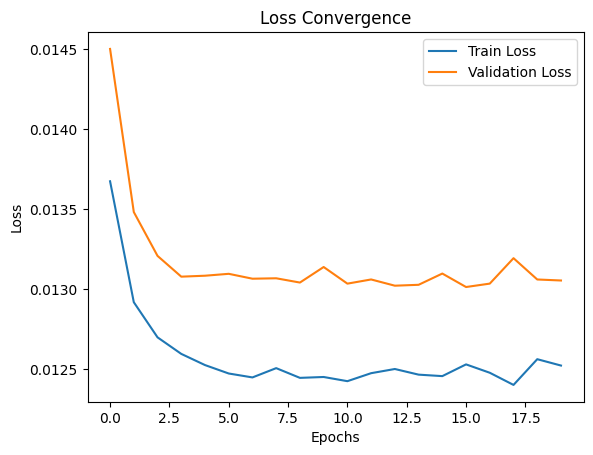

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Convergence")
plt.show()
